# CSC413 Lab 5: Transfer Learning and Descent

Transfer learning is a technique where we use neural network weights trained
to complete one task to complet a different task.
In this tutorial, we will go through an example of *transfer learning* to
detect American Sign Language (ASL) gestures letters A-I.
Although we could train a CNN from scratch,
you will see that using CNN weights that are pretrained on a larger dataset and
more complex task provides much better results, all with less training.

American Sign Language (ASL) is a complete, complex language that employs signs made by
moving the hands combined with facial expressions and postures of the body.
It is the primary language of many North Americans who are deaf and is one of several
communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabets are shown below. This lab focuses on
classifying a subset of these hand gesture images using convolutional neural networks.
Specifically, given an image of a hand showing one of the letters A-I, we want to detect
which letter is being represented.

![Image](https://www.lifeprint.com/asl101/fingerspelling/images/abc1280x960.png)

By the end of this lab, you will be able to:

1. Analyze the role of batch normalization and other model architecture choice in a neural network.
2. Define the double descent phenomenon and explain why it occurs.
3. Analyze the shape of the training curve of a convolutional neural network with respect to the double descent phenomenon.
4. Apply transfer learning to solve an image classification task.
5. Compare transfer learning vs. training a CNN from scratch.
6. Identify and suggest corrections for model building issues by inspecting misclassified data.


Acknowledgements:

- Data is collected from a previous machine learning course APS360. Only data
  of students who provided consent is included.

Please work in groups of 1-2 during the lab.

## Submission

If you are working with a partner, start by creating a group on Markus.
If you are working alone,
click "Working Alone".

Submit the generated PDF file `lab05.pdf` on Markus
**containing all your solutions to the Graded Task**s.
Your file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:

- Part 1. Your answer to the question about the splitting of the data into train/validation/test sets. (1 point)
- Part 2. Your comparison of the CNN model with and without batch normalization. (1 point)
- Part 2. Your comparison of `BatchNorm1d` vs `BatchNorm2d`.  (1 point)
- Part 2. Your analysis of the effect of varying the CNN model width. (1 point)
- Part 2. Your analysis of the effect of varying weight decay parameter. (1 point)
- Part 2. Your analysis of the training curve that illustrates double descent. (1 point)
- Part 3. Your implementation of `LinearModel` for transfer learning. (1 point)
- Part 3. Your comparison of transfer learning vs the CNN model. (1 point)
- Part 4. Your analysis of the confusion matrix. (1 point)
- Part 4. Your explanation for how to mitigate an issue we notice by visually inspecting misclassified images. (1 point)

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets

%matplotlib inline

## Part 1. Data

We will begin by downloading the data onto Google Colab.

In [ ]:
# Download lab data file
!wget https://www.cs.toronto.edu/~lczhang/413/asl_data.zip
!unzip asl_data.zip

--2024-03-15 00:55:20--  https://www.cs.toronto.edu/~lczhang/413/asl_data.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5750695 (5.5M) [application/zip]
Saving to: ‘asl_data.zip’

asl_data.zip        100%[===================>]   5.48M  24.2MB/s    in 0.2s    

2024-03-15 00:55:21 (24.2 MB/s) - ‘asl_data.zip’ saved [5750695/5750695]

Archive:  asl_data.zip
   creating: asl_data/
   creating: asl_data/valid/
   creating: asl_data/test/
   creating: asl_data/train/
   creating: asl_data/valid/I/
   creating: asl_data/valid/G/
   creating: asl_data/valid/A/
   creating: asl_data/valid/F/
   creating: asl_data/valid/H/
   creating: asl_data/valid/C/
   creating: asl_data/valid/D/
   creating: asl_data/valid/E/
   creating: asl_data/valid/B/
   creating: asl_data/test/I/
   creating: asl_data/test/G/
   creating: asl_data/test/A/

The file structure we use is intentional,
so that we can use `torchvision.datasets.ImageFolder`
to help load our data and create labels.

You can read what `torchvision.datasets.ImageFolder` does for us here
https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder

In [ ]:
train_path = "asl_data/train/" # edit me
valid_path = "asl_data/valid/" # edit me
test_path = "asl_data/test/"   # edit me

train_data = torchvision.datasets.ImageFolder(train_path, transform=torchvision.transforms.ToTensor())
valid_data = torchvision.datasets.ImageFolder(valid_path, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.ImageFolder(test_path, transform=torchvision.transforms.ToTensor())

As in previous labs, we can iterate through the dataset one training data point at a time like this:

tensor([[[0.6706, 0.6549, 0.6275,  ..., 0.6706, 0.6706, 0.6706],
         [0.6706, 0.6549, 0.6314,  ..., 0.6706, 0.6706, 0.6706],
         [0.6706, 0.6549, 0.6314,  ..., 0.6706, 0.6706, 0.6706],
         ...,
         [0.5647, 0.5765, 0.5137,  ..., 0.8902, 0.8902, 0.8902],
         [0.5569, 0.5765, 0.5176,  ..., 0.8902, 0.8902, 0.8902],
         [0.5569, 0.5765, 0.5176,  ..., 0.8902, 0.8902, 0.8902]],

        [[0.6588, 0.6431, 0.6157,  ..., 0.6588, 0.6588, 0.6588],
         [0.6588, 0.6431, 0.6196,  ..., 0.6588, 0.6588, 0.6588],
         [0.6588, 0.6431, 0.6196,  ..., 0.6588, 0.6588, 0.6588],
         ...,
         [0.5725, 0.5843, 0.5176,  ..., 0.8902, 0.8902, 0.8902],
         [0.5647, 0.5843, 0.5216,  ..., 0.8902, 0.8902, 0.8902],
         [0.5647, 0.5843, 0.5216,  ..., 0.8902, 0.8902, 0.8902]],

        [[0.6392, 0.6235, 0.5961,  ..., 0.6314, 0.6314, 0.6314],
         [0.6392, 0.6235, 0.6000,  ..., 0.6314, 0.6314, 0.6314],
         [0.6392, 0.6235, 0.6000,  ..., 0.6314, 0.6314, 0.

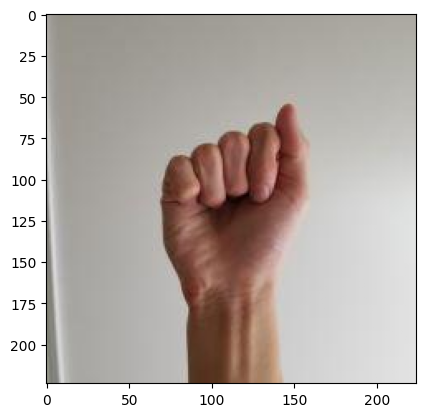

In [ ]:
for x, t in train_data:
    print(x, t)
    plt.imshow(x.transpose(2, 0).transpose(0, 1).numpy()) # display an image
    break # uncomment if you'd like

**Task**: What do the variables `x` and `t` contain? What is the shape of our images?
What are our labels? Based on what you learned in Part (a), how were the
labels generated from the folder structure?

In [ ]:
# Variable 'x' contains the image data, and variable 't' contains the label of
# this image. From the generated image, we can notice that the shape of
# our image is 225 x 225 and our label is a single number (e.g. 0 represents A).
# Also, from what we learned from the link, 'ImageFolder' generates labels based
# on the subdirectory structure within the specific path. It can automatically
# assign labels to images. Each unique folder is considered as a spearate class
# and all the images in this folder are assigned to this class.

We saw in the earlier tutorials that PyTorch has a utility to help us
creat minibatches with our data. We can use the same DataLoader helper
here:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

for x, t in train_loader:
    print(x, t)
    break # uncomment if you'd like

tensor([[[[0.6471, 0.6471, 0.6471,  ..., 0.7765, 0.7725, 0.7725],
          [0.6431, 0.6471, 0.6510,  ..., 0.7686, 0.7686, 0.7686],
          [0.6196, 0.6314, 0.6431,  ..., 0.7569, 0.7647, 0.7647],
          ...,
          [0.4235, 0.4235, 0.4235,  ..., 0.5098, 0.5059, 0.5020],
          [0.4235, 0.4275, 0.4275,  ..., 0.5176, 0.5137, 0.5098],
          [0.4235, 0.4275, 0.4314,  ..., 0.5294, 0.5255, 0.5255]],

         [[0.6275, 0.6275, 0.6275,  ..., 0.7647, 0.7608, 0.7608],
          [0.6235, 0.6275, 0.6314,  ..., 0.7569, 0.7569, 0.7569],
          [0.6000, 0.6118, 0.6235,  ..., 0.7451, 0.7529, 0.7529],
          ...,
          [0.4118, 0.4118, 0.4118,  ..., 0.5098, 0.5059, 0.5020],
          [0.4039, 0.4078, 0.4157,  ..., 0.5176, 0.5137, 0.5098],
          [0.4039, 0.4078, 0.4196,  ..., 0.5294, 0.5255, 0.5255]],

         [[0.6118, 0.6118, 0.6118,  ..., 0.7451, 0.7412, 0.7412],
          [0.6078, 0.6118, 0.6157,  ..., 0.7373, 0.7373, 0.7373],
          [0.5843, 0.5961, 0.6078,  ..., 0

**Task**: What do the variables `x` and `t` contain? What are their shapes?
What data do they contain?

In [ ]:
# Variable x contains 10 images and variable t contains the corresponding
# labels of these 10 iamges.
# The shape of variable x is [10, 3, 224, 224]. It contains the color data
# for each pixel (RGB data since channel is 3).
# The shape of variable t is [10]. It contains the numerical labels
# (like 0 for 'A').

**Task**: How many images are there in the training, validation, and test sets?

In [ ]:
# Train data length is 207, valid data length is 733,
# and test data length is 223.

Notice that there are *fewer* images in the training set, compared to the validation and test sets.
This is so that we can explore the effect of having a limited training set.

**Graded Task**: The data set is generated by students taking pictures of their hand
while making the corresponding gestures. We therefore split the
training, validation, and test sets were split so that images generated by
a student all belongs in a single data set. In other words, we avoid cases where
some students' images are in the training set and others end up in the test set.
Why do you think this is important for obtaining a representative test accuracy?

In [ ]:
# I think this measure can avoid overfitting to a extent.
# If images from the same student appear in both train and test data, our model
# might memorize specific characteristics such us unique patterns of this
# student's hand, instead of the actual hand gesture. It helps our model to
# learn the general patterns that correspond to the ASL gestures. Otherwise,
# we may get good performance on training and testing data in this specific case,
# but fail to generalize the new data from different students, which is more common
# in the real world.
# Therefore, splitting the training, validation, and test sets in such way is important
# for getting representative test accuracy.

## Part 2. Training a CNN Model

For this part, we will be working with this CNN network.

In [ ]:
class CNN(nn.Module):
    def __init__(self, width=4, bn=True):
        """
        A 4-layer convolutional neural network. The first layer has
        `width` number of channels, and with each layer we half the
        feature width/height and double the number of channels.

        If `bn` is set to False, then batch normalization will not run.
        """
        super(CNN, self).__init__()
        self.width = width
        self.bn = bn
        # define all the conv layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=self.width,
                               kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.width,
                               out_channels=self.width*2,
                               kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=self.width*2,
                               out_channels=self.width*4,
                               kernel_size=3,
                               padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.width*4,
                               out_channels=self.width*8,
                               kernel_size=3,
                               padding=1)
        # define all the BN layers
        if bn:
            self.bn1 = nn.BatchNorm2d(self.width)
            self.bn2 = nn.BatchNorm2d(self.width*2)
            self.bn3 = nn.BatchNorm2d(self.width*4)
            self.bn4 = nn.BatchNorm2d(self.width*8)
        # pooling layer has no parameter, so one such layer
        # can be shared across all conv layers
        self.pool = nn.MaxPool2d(2, 2)
        # FC layers
        self.fc1 = nn.Linear(self.width * 8 * 14 * 14, 100)
        self.fc2 = nn.Linear(100, 9)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        if self.bn:
            x = self.bn1(x)
        x = self.pool(torch.relu(self.conv2(x)))
        if self.bn:
            x = self.bn2(x)
        x = self.pool(torch.relu(self.conv3(x)))
        if self.bn:
            x = self.bn3(x)
        x = self.pool(torch.relu(self.conv4(x)))
        if self.bn:
            x = self.bn4(x)
        x = x.view(-1, self.width * 8 * 14 * 14)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

**Task**: The training code is written for you. Train the `CNN()` model for at least 6 epochs, and report
on the maximum validation accuracy that you can attain.

As your model is training, you might want to move on to the next question.

In [ ]:
def get_accuracy(model, data, device="cpu"):
    loader = torch.utils.data.DataLoader(data, batch_size=256)
    model.to(device)
    model.eval() # annotate model for evaluation (important for batch normalization)
    correct = 0
    total = 0
    for imgs, labels in loader:
        labels = labels.to(device)
        output = model(imgs.to(device))
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_model(model,
                train_data,
                valid_data,
                batch_size=64,
                weight_decay=0.0,
                learning_rate=0.001,
                num_epochs=50,
                plot_every=20,
                plot=True,
                device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    model = model.to(device) # move model to GPU if applicable
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    # for plotting
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for epoch in range(num_epochs):
            for imgs, labels in iter(train_loader):
                if imgs.size()[0] < batch_size:
                    continue
                labels = labels.to(device)
                imgs = imgs.to(device)
                model.train()
                out = model(imgs)
                loss = criterion(out, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                iter_count += 1
                if iter_count % plot_every == 0:
                    loss = float(loss)
                    tacc = get_accuracy(model, train_data, device)
                    vacc = get_accuracy(model, valid_data, device)
                    print("Iter %d; Loss %f; Train Acc %.3f; Val Acc %.3f" % (iter_count, loss, tacc, vacc))

                    iters.append(iter_count)
                    train_loss.append(loss)
                    train_acc.append(tacc)
                    val_acc.append(vacc)
    finally:
        plt.figure()
        plt.plot(iters[:len(train_loss)], train_loss)
        plt.title("Loss over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")

        plt.figure()
        plt.plot(iters[:len(train_acc)], train_acc)
        plt.plot(iters[:len(val_acc)], val_acc)
        plt.title("Accuracy over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.legend(["Train", "Validation"])

**Task**: Run the training code below. What validation accuracy can be achieved by this CNN?

Iter 25; Loss 0.033621; Train Acc 0.092; Val Acc 0.098
Iter 50; Loss 0.002367; Train Acc 1.000; Val Acc 0.533
Iter 75; Loss 0.001270; Train Acc 1.000; Val Acc 0.553
Iter 100; Loss 0.000681; Train Acc 1.000; Val Acc 0.555
Iter 125; Loss 0.000626; Train Acc 1.000; Val Acc 0.555
Iter 150; Loss 0.000583; Train Acc 1.000; Val Acc 0.554


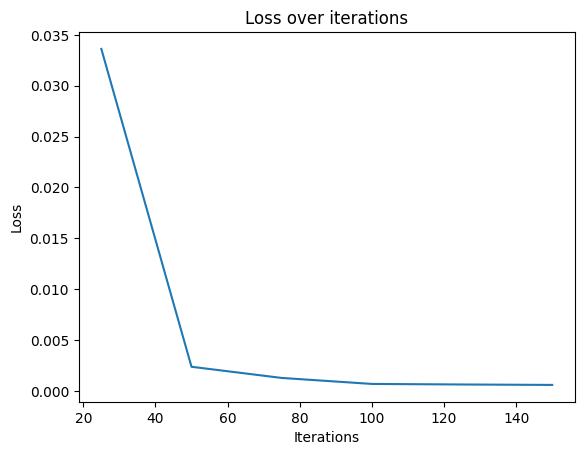

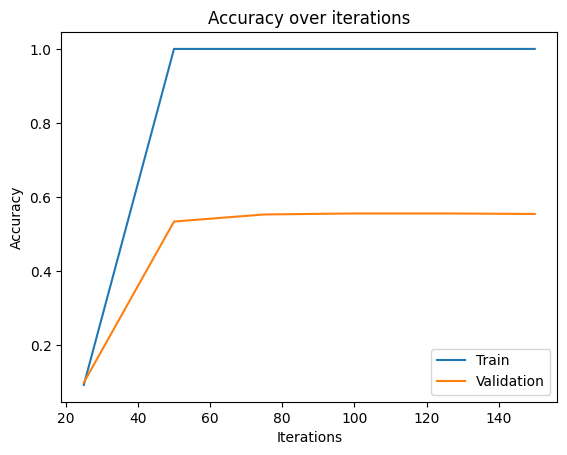

In [ ]:
cnn = CNN(width=4)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

In [ ]:
# This CNN model achieved an accuracy of ~0.55.

## Part 2. Model Architecture, Bias/Variance and Double Descent

In this section, we will explore the effect of various aspects of
a CNN model architecture. We will pay particluar attention to
architecture decisions that affect the bias and variance of the
model. Finally, we explore a phenomenon called **double descent**.


To begin, let's explore the effect of batch normalization.

**Task**: Run the training code below to explore the effect of training *without* batch normalization.

Iter 25; Loss 2.128376; Train Acc 0.193; Val Acc 0.141
Iter 50; Loss 0.965653; Train Acc 0.729; Val Acc 0.453
Iter 75; Loss 0.312504; Train Acc 0.889; Val Acc 0.512
Iter 100; Loss 0.198689; Train Acc 0.903; Val Acc 0.535
Iter 125; Loss 0.056553; Train Acc 0.995; Val Acc 0.547
Iter 150; Loss 0.014043; Train Acc 1.000; Val Acc 0.572


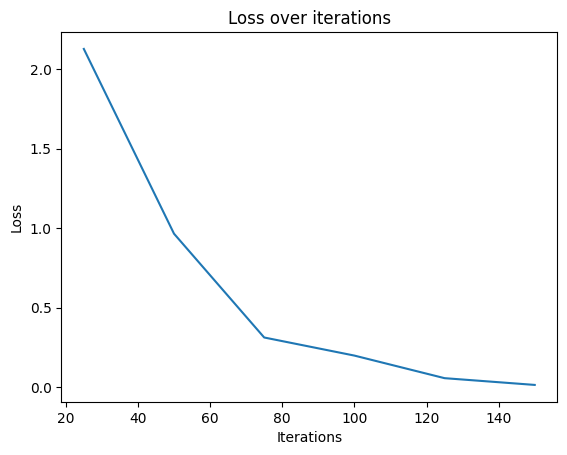

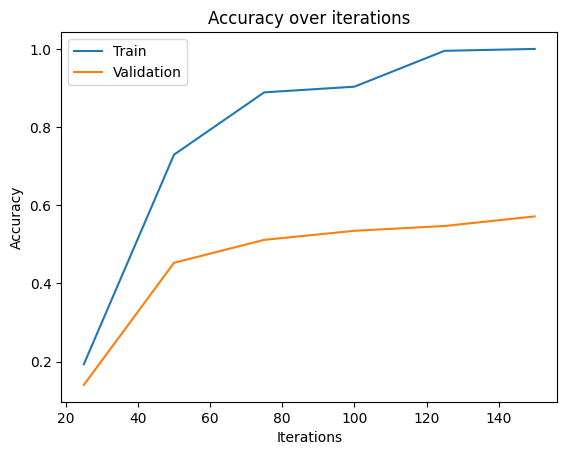

In [ ]:
cnn = CNN(bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

**Graded Task**: Compare the two sets of training curves above for the CNN model with and without
batch normalization. What is the effect of batch normalization on the training loss and accuracy?
What about the validation accuracy?

In [ ]:
# For training loss, we can notice that batch normalization helps our
# CNN model to converge faster.
#
# For training accuracy, batch normalization helps our model to
# perfectly fit the training data (got 1.0 train accuracy) relatively
# early in the training process.
#
# For validation accuracy, batch normalization helps our model to improve
# its generalization capability over time. This can be shown when iteration
# above 100, model with bn has steady improvement while model without bn shows
# a fluctuation.

**Graded Task**:
We used the layer called `BatchNorm2d` in our CNN.
What do you think is the difference between `BatchNorm2d` and `BatchNorm1d`?
Why are we using `BatchNorm2d` in our CNN? Why would we use `BatchNorm1d` in an MLP?
You may wish to consult the PyTorch documentation. (How can you find it?)

In [ ]:
# I think the main difference between BatchNorm2d and BatchNorm1d is the type
# of data they normalize: BatchNorm2d is used for 2-dimensional data (like our
# scenario: use CNN to process image data), while BatchNorm1d is used for
# 1-dimensional data.
#
# The reason we use BatchNorm2d in our CNN is that we try to use
# CNN to process 2d image data, and it is necessary to normalize these images
# across both the batch and 2d dimensions (on height and width) to maintain
# consistent scale and distribution of inputs across the network layers.
#
# We use BatchNorm1d in an MLP because the data is 1d and the normalization
# process is applied across the batch for each feature independently.
# The documentations are found on pytorch.org.

**Task**: Run the training code below to explore the effect of varying the model width
for this particular data set.

Iter 25; Loss 2.200727; Train Acc 0.130; Val Acc 0.111
Iter 50; Loss 2.162607; Train Acc 0.130; Val Acc 0.108
Iter 75; Loss 1.766431; Train Acc 0.377; Val Acc 0.273
Iter 100; Loss 0.970690; Train Acc 0.686; Val Acc 0.467
Iter 125; Loss 0.652281; Train Acc 0.826; Val Acc 0.536
Iter 150; Loss 0.253160; Train Acc 0.928; Val Acc 0.540


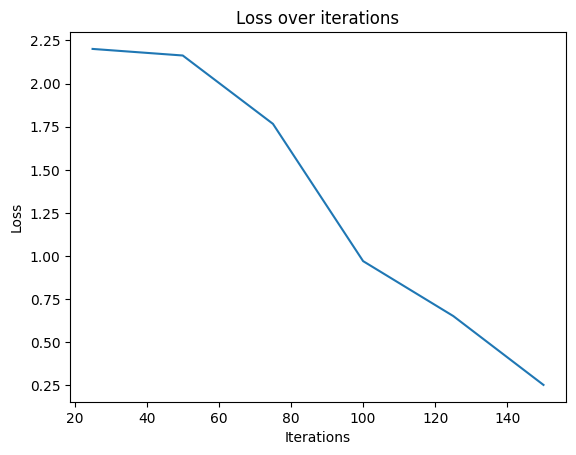

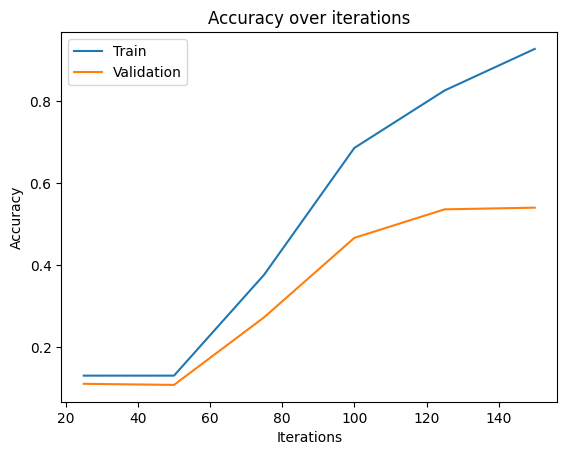

In [ ]:
cnn = CNN(width=2, bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

Iter 25; Loss 2.187584; Train Acc 0.130; Val Acc 0.111
Iter 50; Loss 2.132602; Train Acc 0.314; Val Acc 0.281
Iter 75; Loss 0.958957; Train Acc 0.725; Val Acc 0.472
Iter 100; Loss 0.234617; Train Acc 0.899; Val Acc 0.512
Iter 125; Loss 0.097633; Train Acc 0.971; Val Acc 0.558
Iter 150; Loss 0.022335; Train Acc 1.000; Val Acc 0.573


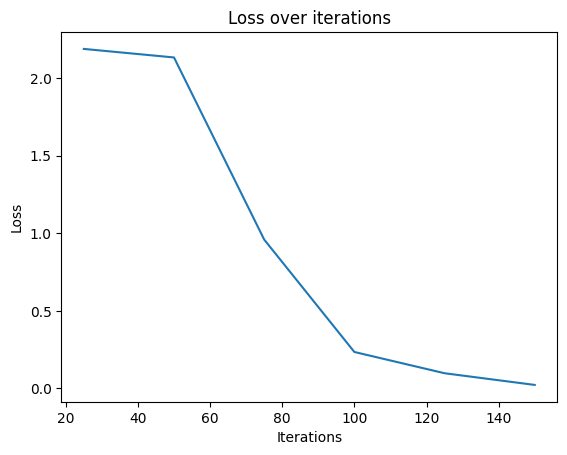

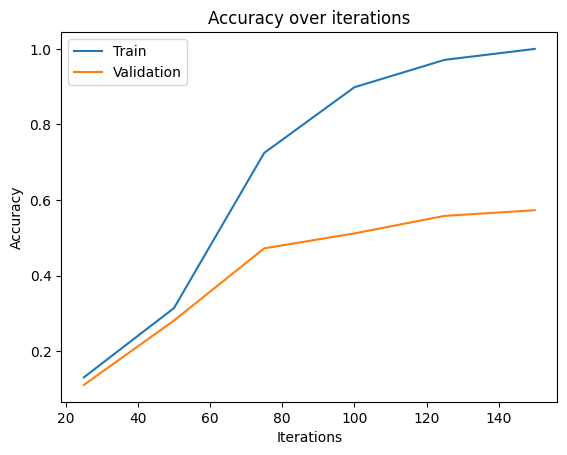

In [ ]:
cnn = CNN(width=4, bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

Iter 25; Loss 1.120249; Train Acc 0.686; Val Acc 0.427
Iter 50; Loss 0.212190; Train Acc 0.918; Val Acc 0.523
Iter 75; Loss 0.040420; Train Acc 0.995; Val Acc 0.555
Iter 100; Loss 0.024761; Train Acc 1.000; Val Acc 0.523
Iter 125; Loss 0.001038; Train Acc 1.000; Val Acc 0.531
Iter 150; Loss 0.000224; Train Acc 1.000; Val Acc 0.538


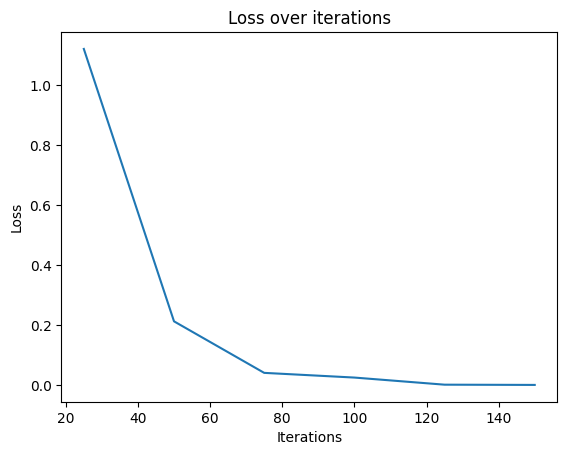

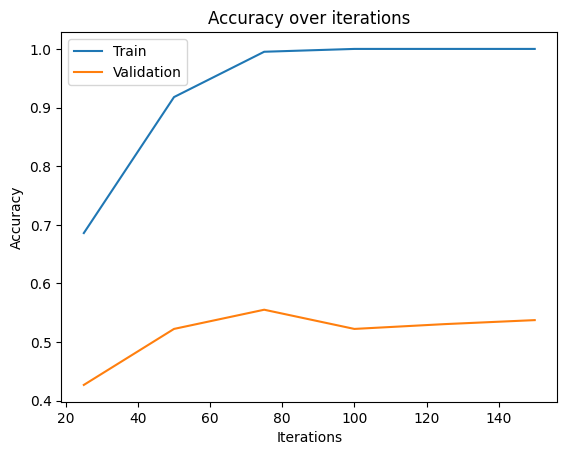

In [ ]:
cnn = CNN(width=16, bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

**Graded Task**: What is the effect of varying the model width above for this particular data set?
Do you notice an effect on the training loss? What about the training/validation accuracy?
The final validation accuracy?
(Your answer may or may not match your expectations. Please answer based on the actual results above.)

In [ ]:
# For the training loss, we notice that as the width of the model increases,
# the final training loss shows a decrease, and we also can notice a speed of
# decrease for training loss increase when the width of the model increases.
#
# For the training accuracy, there is a clear trend that as the width of the
# model increases, the training accuracy improves faster. We can compare the
# CNN model with width=16 and the CNN model with width=2. When iter=75, the
# training accuracy for model with width 16 reaches nearly perfect fit (0.995)
# while model with width 2 only gets 0.337.
#
# For the final validation accuracy, we can learn that as the width increases,
# the final validation accuracy improves.

**Task**: Run the training code below to explore the effect of weight decay when training a large model.

Iter 25; Loss 0.747723; Train Acc 0.676; Val Acc 0.434
Iter 50; Loss 0.178543; Train Acc 0.966; Val Acc 0.598
Iter 75; Loss 0.013796; Train Acc 0.995; Val Acc 0.565
Iter 100; Loss 0.001089; Train Acc 1.000; Val Acc 0.585
Iter 125; Loss 0.000460; Train Acc 1.000; Val Acc 0.577
Iter 150; Loss 0.000776; Train Acc 1.000; Val Acc 0.574


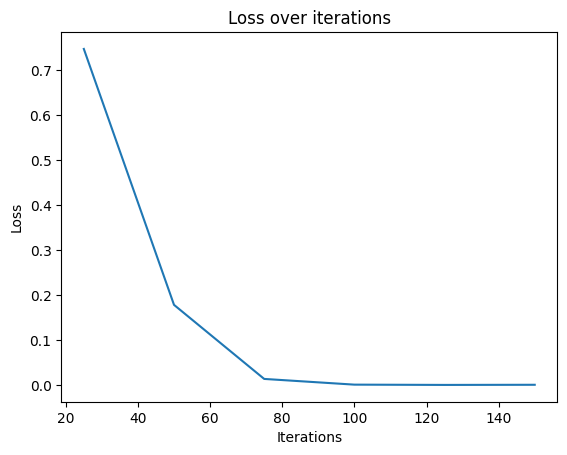

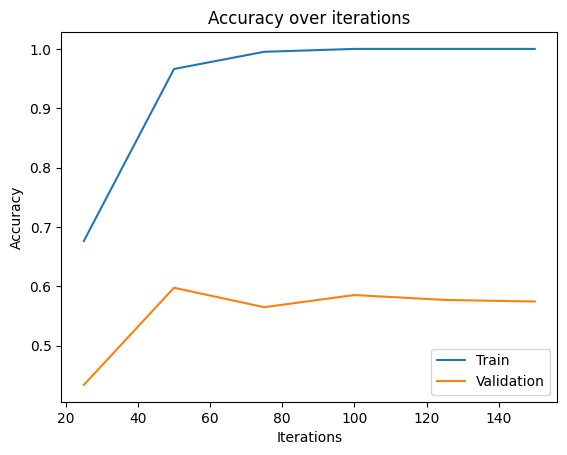

In [ ]:
cnn = CNN(width=16, bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25, weight_decay=0.001)

Iter 25; Loss 0.011621; Train Acc 0.106; Val Acc 0.145
Iter 50; Loss 0.000834; Train Acc 0.787; Val Acc 0.480
Iter 75; Loss 0.000721; Train Acc 0.995; Val Acc 0.576
Iter 100; Loss 0.000504; Train Acc 1.000; Val Acc 0.570
Iter 125; Loss 0.000405; Train Acc 1.000; Val Acc 0.563
Iter 150; Loss 0.000551; Train Acc 1.000; Val Acc 0.561


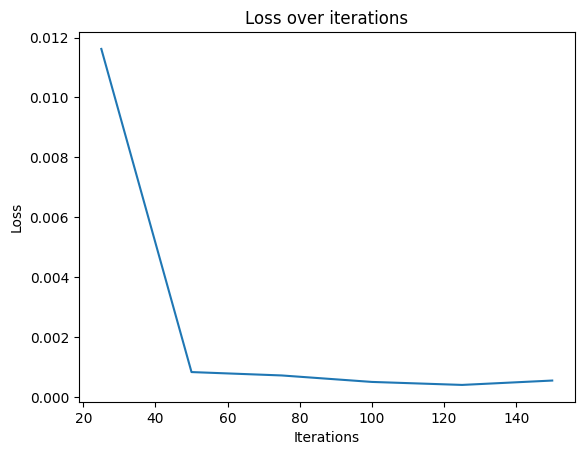

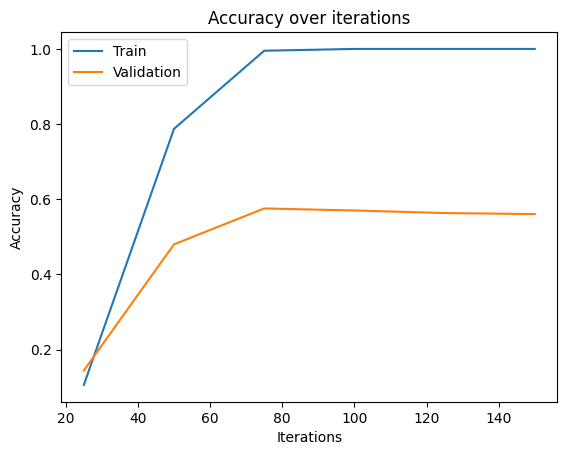

In [ ]:
cnn = CNN(width=16, bn=True) # try with batch norm on
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25, weight_decay=0.001)

Iter 25; Loss 0.018150; Train Acc 0.338; Val Acc 0.254
Iter 50; Loss 0.001908; Train Acc 0.937; Val Acc 0.495
Iter 75; Loss 0.000441; Train Acc 1.000; Val Acc 0.548
Iter 100; Loss 0.000559; Train Acc 1.000; Val Acc 0.562
Iter 125; Loss 0.000327; Train Acc 1.000; Val Acc 0.572
Iter 150; Loss 0.000328; Train Acc 1.000; Val Acc 0.572


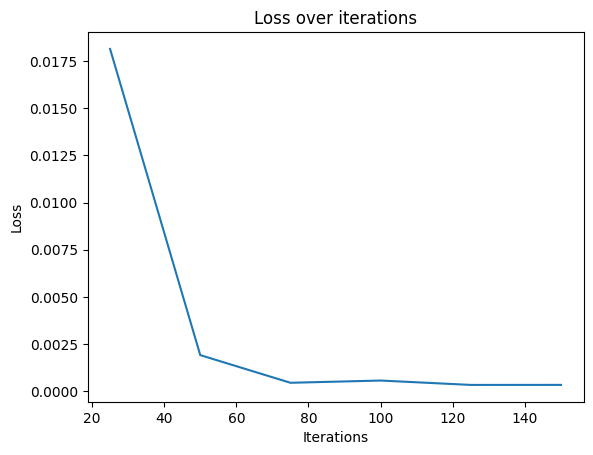

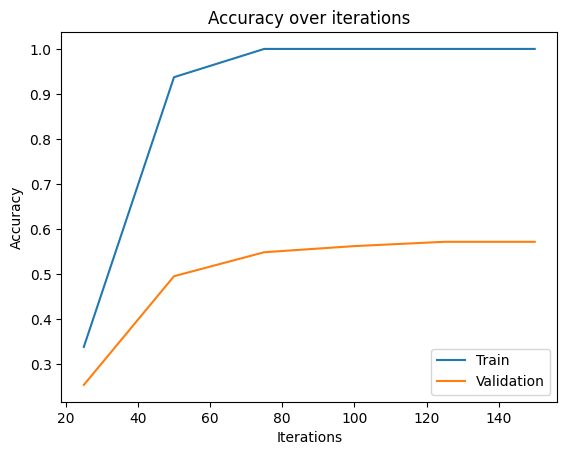

In [ ]:
cnn = CNN(width=16, bn=True) # try decreasing weight decay parameter
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25, weight_decay=0.0001)

**Graded Task**: What is the effect of setting weight decay to the above value?
Do you notice an effect on the training loss? What about the training/validation accuracy?
The final validation accuracy?
(Again, your answer may or may not match your expectations. Please answer based on the actual results above.)

In [ ]:
# In order to observe the effect of weight decay, we can compare the outputs
# of the setting 'weight decay=0.001 with bn=True' and 'weight decay=0.0001
# with bn=True'.
#
# For the training loss, we notice that both training loss shows a rapid
# decrease first then slightly decrease. However, lower weight decay can
# get a smaller final training loss (0.000551 for weight decay=0.001 and
# 0.000328 for weight decay=0.0001)
#
# For the training accuracy, we can notice that reducing the weight decay
# (from 0.001 to 0.0001) seems to allow the model to learn faster (when iter=75,
# the training accuracy is 0.995 for setting weight decay to 0.001 while
# training accuracy reachs 1.0 for setting weight decay to 0.0001).
#
# For the final validation accuracy, it can be observed that when setting to
# lower weight decay, the final validation accuracy becomes slightly higher.

**Task**: Note that there is quite a bit of noise in the results that we might obtain above.
That is, if you run the same code twice, you may obtain different answers.
Why might that be? What are two sources of noise/randomness?

In [ ]:
# I think our training process might be affected by various randomness.
# The two sources of noise could be ramdomly initialized weights, and
# learning rate adaptations in our optimization algorithm (Adam).

These settings that we have been exporting are hyperparameters that should
be tuned when you train a neural network. These hyperparameters interact with
one another, and thus we should tune them using the **grid search** strategy
mentioned in previous labs.

You are not required to perform grid search for this lab, so that we can
explore a few other phenomena.

One interesting phenomenon is called **double descent**. In statistical learning theory,
we expect validation error to *decrease* with increase model capacity, and then *increase*
as the model overfits to the number of data points available for training.
In practise, in neural networks, we often see that as model capacity increases,
validation error first decreases, then increase, and then **decrease again**---hence
the name "double descent".

In fact, the increase in validation error is actually quite subtle.
However, what is readily apparent is that in most cases, increasing
model capacity does *not* result in a decrease in validation accuracy.

**Optional Task**: To illustrate that validation accuracy is unlikely to decrease
with increased model parameter, train the below network.

In [ ]:
# Uncomment to run.
# cnn = CNN(width=40, bn=True)
# train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=50)

Double descent is actually not that mysterious. It comes from the fact that
when capacity is large enough there are many parameter choices that achieves 100% training accuracy,
the neural network optimization procedure is effectively choosing a *best parameters*
out of the many that can achieve this perfect training accuracy. This differs from
when capacity is low, where the optimization process needs to find a set of parameter choices that
best fits the training data---since no choice of parameters fits the training data perfectly.
When the capacity is just large enough to be able to find parameters that fit the data,
but too small for there be a range of parameter choices available to be able to select a "best" one.

This twitter thread written by biostatistics professor Daniela Witten
also provides an intuitive explanation, using polynomial curve fitting
as an example: [https://twitter.com/daniela_witten/status/1292293102103748609](https://twitter.com/daniela_witten/status/1292293102103748609)

Double descent explored in depth in this paper here:
[https://openreview.net/pdf?id=B1g5sA4twr](https://openreview.net/pdf?id=B1g5sA4twr)
This paper highlights that the increase in validation/test error occurs
when the training accuracy approximates 100%.
Moreover, the double descent phenomena is noticable when varying model capacity (e.g. number of parameters)
and when varying the number of iterations/epochs of training.

We will attempt to explore the latter effect---i.e. we will train a large model, use a small
number of training data points, and explore how each iteration of training impacts validation accuracy.
The effect is subtle and, depending on your neural network initialization, you may not see an effect.
An examplary training curve is also provided for you to analyze.

**Optional Task**: Run the code below to try and reproduce the "double descent" phenomena.
This code will take a while to run, so you may wish to continue with the remaining questions
while it runs.

In [ ]:
# use a subset of the training data
# uncomment to train

# train_data_subset, _ =  random_split(train_data, [50, len(train_data)-50])
# cnn = CNN(width=20)
# train_model(cnn,
#             train_data_subset,
#             valid_data,
#             batch_size=50, # set batch_size=len(train_data_subset) to minimize training noise
#             num_epochs=200,
#             plot_every=1,  # plot every epoch (this is slow)
#             learning_rate=0.0001)  # choose a low learning rate

For reference, here is the our training curve showing the loss and accuracy over 200 iterations:

<img src="https://www.cs.toronto.edu/~lczhang/413/double_descent_loss.png" width=400>
<img src="https://www.cs.toronto.edu/~lczhang/413/double_descent.png" width=400>

It might not be possible to consistently reproduce this result (e.g., due to initialization),
so it is totally reasonable for your figure to look different!


**Task**: In the provided training curve,
during which iterations does the validation accuracy initially increase
(i.e. validation error decrease)?

In [ ]:
# I find that around iterations=27, the validation accuracy initially increase.

**Graded Task**: In the provided training curve,
during which iterations do the validation accuracy decrease slightly?
Approximately what training accuracy is achieved at this piont?

In [ ]:
# I find that around iterations=70, the validation accuracy decrease slightly.
# At this point, training accuracy is approximately 0.95.

**Task**: In the provided training curve,
during which iterations do the validation accuracy increase for a second time
(i.e. validation error descends for a second time)?

In [ ]:
# I find that about iterations=83, the validation accuracy increase for a
# second time.

## Part 3. Transfer Learning

For many image classification tasks, it is generally not a good idea to train a
very large deep neural network model from scratch due to the enormous compute
requirements and lack of sufficient amounts of training data.

A better option is to try using an existing model that performs a
similar task to the one you need to solve. This method of utilizing a
pre-trained network for other similar tasks is broadly termed
**Transfer Learning**. In this assignment, we will use Transfer Learning
to extract features from the hand gesture images. Then, train a smaller
network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various
features from the images which get utilized by the fully connected layers
for correct classification. AlexNet architecture played a pivotal role in
establishing Deep Neural Nets as a go-to tool for image classification
problems and we will use an ImageNet pre-trained AlexNet model to
extract features in this assignment.

Here is the code to load the AlexNet network, with pretrained weights.
When you first run the code, PyTorch will download the pretrained weights
from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

print(alexnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 121MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

As you can see, the `alexnet` model is split up into two components:
`alexnet.features` and
`alexnet.classifier`.  The first neural network component, `alexnet.features`,
is used to
computed convolutional features, which is taken as input in `alexnet.classifier`.

The neural network `alexnet.features` expects an image tensor of shape
Nx3x224x224 as inputs and it will output a tensor of shape Nx256x6x6 . (N = batch size).

Here is an example code snippet showing how you can compute the AlexNet
features for some images (your actual code might be different):

In [ ]:
img, label = train_data[0]
features = alexnet.features(img.unsqueeze(0)).detach()

print(features.shape)

torch.Size([1, 256, 6, 6])


Note that the `.detach()` at the end will be necessary in your code. The reason is that
PyTorch automatically builds computation graphs to be able to backpropagate
graidents. If we did not explicitly "detach" this tensor from the AlexNet portion
of the computation graph, PyTorch might try to backpropagate gradients to the AlexNet
weight and tune the AlexNet weights.

**Task**: Compute the AlexNet features for each of your training, validation, and test data
by completing the function `compute_features`.
The code below creates three new arrays called `train_data_fets`, `valid_data_fets`
and `test_data_fets`. Each of these arrays contains tuples of the form
`(alexnet_features, label)`.

In [ ]:
def compute_features(data):
    fets = []
    for img, t in data:
        features = alexnet.features(img.unsqueeze(0)).detach()
        fets.append((features, t),)
    return fets

train_data_fets = compute_features(train_data)
valid_data_fets = compute_features(valid_data)
test_data_fets = compute_features(test_data)

In the rest of this part of the lab, we will test two models that
will take **as input** these AlexNet features, and make a prediction
for which letter the hand gesture represents.
The two models are
a linear model, a two-layer MLP.
We will compare the performance of these two models.

**Graded Task**: Complete the definition of the `LinearModel` class,
which is a linear model (e.g., logistic regression).
This model should as input these AlexNet features, and make a prediction
for which letter the hand gesture represents.

In [ ]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        # TODO: What layer need to be initialized?
        # Ans: fully connected layer
        self.fc = nn.Linear(1*256*6*6, 10)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) # flatten the input
        z = self.fc(x) # TODO: What computation needs to be performed?
        return z

m_linear = LinearModel()
m_linear(train_data_fets[0][0]) # this should produce a(n unnormalized) prediction

tensor([[ 0.4708, -0.1693, -0.0708, -0.0409, -0.1093, -0.7054, -0.6223, -0.1863,
          0.7586,  0.5179]], grad_fn=<AddmmBackward0>)

**Task**:
Train a `LinearModel()` for at least 6 epochs, and report
on the maximum validation accuracy that you can attain.
We should still be able to use the `train_model` function, but
make sure to provide the AlexNet features as input (and not the
image features).

Iter 10; Loss 0.764621; Train Acc 0.729; Val Acc 0.630
Iter 20; Loss 0.689072; Train Acc 0.952; Val Acc 0.765
Iter 30; Loss 0.249727; Train Acc 0.947; Val Acc 0.835
Iter 40; Loss 0.238442; Train Acc 0.990; Val Acc 0.814
Iter 50; Loss 0.080449; Train Acc 0.976; Val Acc 0.768
Iter 60; Loss 0.131055; Train Acc 0.986; Val Acc 0.881
Iter 70; Loss 0.007319; Train Acc 1.000; Val Acc 0.884
Iter 80; Loss 0.009571; Train Acc 1.000; Val Acc 0.838
Iter 90; Loss 0.008644; Train Acc 1.000; Val Acc 0.896
Iter 100; Loss 0.036840; Train Acc 1.000; Val Acc 0.906
Iter 110; Loss 0.021889; Train Acc 1.000; Val Acc 0.888
Iter 120; Loss 0.013443; Train Acc 1.000; Val Acc 0.891
Iter 130; Loss 0.027831; Train Acc 1.000; Val Acc 0.896
Iter 140; Loss 0.004457; Train Acc 1.000; Val Acc 0.898
Iter 150; Loss 0.005674; Train Acc 1.000; Val Acc 0.895
Iter 160; Loss 0.011124; Train Acc 1.000; Val Acc 0.896


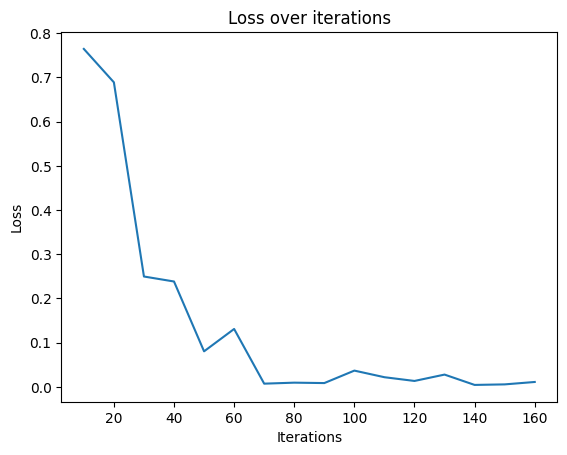

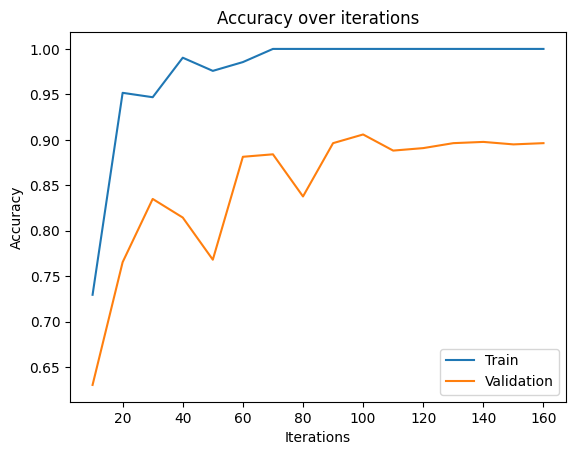

In [ ]:
m_linear = LinearModel()
# TODO: Train the linear model. Include your output in your submission
train_model(m_linear, train_data_fets, valid_data_fets, batch_size=10, learning_rate=0.001, num_epochs=8, plot_every=10)

**Graded Task**: Compare this model with the CNN() models that we trained
earlier. How does this model perform in terms of validation accuracy?
What about in terms of the time it took to train this model?

In [ ]:
# Based on the validation accuracy curve, we can notice that the final
# validation accuracy is much better than the result we run on CNN models.
# The accracy has increased form ~0.6 to ~0.9.
# For the running time, this linear model performs far more better than
# the CNN models. The CNN model needed a few minuts to run, and this only took
# a few seconds.

**Task**:
We decide to use AlexNet features as input to our MLP, and avoided tuning AlexNet
weights. However, we could have considered AlexNet to be a part of our model, and
continue to tune AlexNet weights to improve our model performance. What are the
advantages and disadvantages of continuing to tune AlexNet weights?

In [ ]:
# The advantage would be, after tuning, the model would perform better on our specific
# task of recognizing hand gestures. The disadvantage would be the increasing risk
# of overfitting and possible increase of running time.

## Part 4. Data

**Task**: Report the test accuracy on this transfer learning model.

In [ ]:
test_accuracy = get_accuracy(m_linear, test_data_fets)
print(f"The test accuracy of our transfer learning model is {test_accuracy}")

The test accuracy of our transfer learning model is 0.7892376681614349


**Task**: Use this code below to construct the confusion matrix for this model
over the test set.

<Figure size 640x480 with 0 Axes>

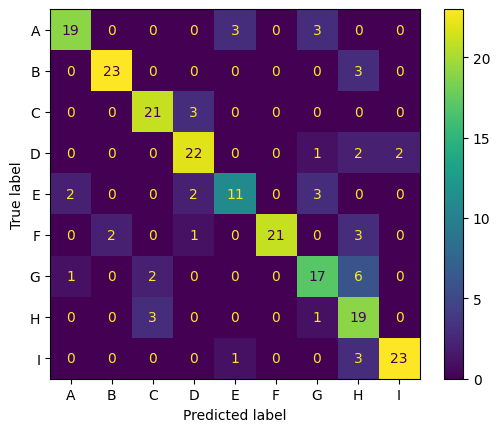

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sklearn
label = "ABCDEFGHI"
def plot_confusion(model, data):
    n = 0
    ts = []
    ys = []
    for x, t in data:
        z = model(x.unsqueeze(0))
        y = int(torch.argmax(z))
        ts.append(t)
        ys.append(y)

    cm = confusion_matrix(ts, ys)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
    plt.figure()
    disp.plot()

plot_confusion(m_linear, test_data_fets)

**Graded Task**: Which class is most likely mistaken as another?
Is this reasonable? (i.e. is that class particularly challenging, or
very similar to another class?)

In [ ]:
# The class is "H", and it seems to be similar to class G, and slightly similar to class B, F, I, and also been mistaken
# from D as well. This might be due to the hand gesture of H is hard to recognize.

**Task**: In order to understand where errors come from, it is *crucial* that
we explore why and how our models fail. A first step is to visually inspect the
test data points where failure occurs. That way, we can identify what we can do
to prevent/fix errors before our models are deployed.

Run the below code to display images in the test set that our model *misclassifies*:

In [ ]:
for i, (x, t) in enumerate(test_data_fets):
    y = int(torch.argmax(m_linear(x)))
    if not (y == t):
        plt.figure()
        plt.imshow(test_data[i][0].transpose(0,1).transpose(1,2).numpy())

**Task**: By visually inspecting these misclassified images, we see that there are
two main reasons for misclassification. What reason for misclassification is
due to a mistake in the formatting of the test set images?

In [ ]:
# 1. Direction: We can identify the case that different direction of hands might
# be a source of misclassification. The model may be learning the direction of hand,
# instead of the gesture it's posing.
# 2. image's features: The lighting might be an issue. For a letter the hand need to show
# 1 finger out, but the shadow on the wall makes it looks like showing 2 fingers out. Another
# case is if a person's finger is shorter or showing with angles, showing the palm and the fist
# may look similar. The different tone of backgorund colour may also be a problem.

**Graded Task**: We also see a much more serious issue, where gestures made by
individuals with darker skin tones may be more frequently misclasified.
This result suggests that errors in the model may impact some groups more than
others. What steps should we take to mitigate this issue?

In [ ]:
# We should use more data of darker skin colour to train the model. If the model
# is used by others, we would need to clearly label it's biases.